# Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import gridspec, lines, legend_handler
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns
import numpy as np
import pandas as pd
import scipy.stats as scs
from statsmodels.formula.api import ols
from os import path
from IPython.display import display


from python_scripts.utils import loc_utils as lut
from python_scripts.utils import vis_utils as vut
from python_scripts.utils.vis_utils import gcolors, glabels, fullglabels, gmarkers, colors, ncolors, tlabels

# Figure 1b

In [ ]:
def make_fig1b(data_path, figname, save_to='LOCAL', save_as=''):
    cols = ['sid', 'grp', 'tid', 'pc_first']
    df = lut.unpickle(data_path)
    df = df.loc[:, cols]
    df = df.replace({'1_1D': 1, '2_I1D': 2, '3_2D': 3, '4_R': 4, 'F': 0, 'S': 1})
    df['percent_correct'] = df.pc_first * 100

    fig = plt.figure(figname, figsize=[5, 5])

    ax = vut.pretty(fig.add_subplot(111))
    palet = sns.set_palette(sns.color_palette(gcolors))
    sns.boxplot(x='tid', y='percent_correct', hue='grp', data=df,
                saturation=1, palette=palet, ax=ax)

    props = {'connectionstyle': 'bar',
             'arrowstyle': '-',
             'patchA': None, 'patchB': None,
             'shrinkA': 10, 'shrinkB': 10,
             'linewidth': 2}
    bh, pad = 100, .025
    for i in range(3):
        ax.text(x=i + .5, y=bh + 15, s='***', fontsize=15, ha='center', va='top')
        ax.annotate('', xy=(i + pad, bh), xytext=(i + 1 - pad, bh), xycoords='data',
                    ha='center', va='top', arrowprops=props)

    ax.set_ylim(0, 115)
    ax.set_xlim(-.5, 3.8)
    ax.set_xlabel('Learning activity', fontsize=15)
    ax.set_ylabel('% correct', fontsize=20)
    ax.set_xticklabels(['A1', 'A2', 'A3', 'A4'], fontsize=15, fontweight='bold')
    for xt, c in zip(ax.get_xticklabels(), colors):
        xt.set_color(c)

    ax.legend_.remove()
    ax.text(3.5, 100, glabels[0], va='top', ha='left',
            fontsize=15, fontweight='bold', color=gcolors[0])
    ax.text(3.5, 80, glabels[1], va='bottom', ha='left',
            fontsize=15, fontweight='bold', color=gcolors[1])

    fig.tight_layout()
    if save_as:
        vut.save_it(fig, save_to, figname, save_as=save_as)



make_fig1b(
    data_path='data/long3.pkl',
    figname='figure1b',
    save_to='figures',
    save_as='' # File format (png, jpeg, svg, ...)
)


# Figure 2a

mean       sem
group activity                     
0     A1        28.807792  1.909293
      A2        23.301299  1.515198
      A3        22.893506  1.303776
      A4        24.997403  1.605830
1     A1        16.161364  1.217458
      A2        19.765909  1.209054
      A3        25.243182  1.156306
      A4        38.829545  1.687827

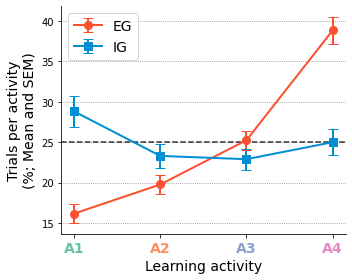

In [29]:
def make_fig2a(data_path, figname, save_to, save_as=None):
    df = pd.read_csv(data_path)[['sid','group','trial','activity']]
    df = df.loc[df.trial <= 60+250].drop(columns='trial')
    counts = df.groupby(['group', 'sid']).activity.value_counts().to_frame('counts')
    counts = ((counts - 15)/250)*100
    counts_stats = counts.groupby(['group','activity']).agg(['mean', 'sem'])
    counts_stats.columns = counts_stats.columns.droplevel(0)
    display(counts_stats)

    fig = plt.figure(figname, figsize=[5, 4])
    ax = vut.pretty(fig.add_subplot(111), 'y')
    ax.axhline(25, ls='--', color='k', alpha=.8)
    x = np.array([1, 2, 3, 4])
    for i, grp in enumerate([1, 0]):
        y = counts_stats.loc[(grp, slice(None)), 'mean']
        yerr = counts_stats.loc[(grp, slice(None)), 'sem']
        ax.errorbar(x, y, yerr=yerr, color=gcolors[grp], marker=gmarkers[grp],
                    capsize=5, markersize=8, lw=2, label=fullglabels[grp])

    ax.set_xticks(x)
    ax.set_xticklabels(['A1', 'A2', 'A3', 'A4'], fontsize=14, fontweight='bold')
    for xt, c in zip(ax.get_xticklabels(), colors):
        xt.set_color(c)

    ax.set_xlabel('Learning activity', fontsize=14)
    ax.set_ylabel('Trials per activity\n(%; Mean and SEM)', fontsize=14)
    leg = ax.legend(fontsize=14)

    fig.tight_layout()
    if save_as:
        vut.save_it(fig, save_to, figname, save_as=save_as, compress=False)


make_fig2a(
    data_path='data/clean_data.csv',
    figname='figure2a',
    save_to='figures',
    save_as='' # File format (png, jpeg, svg, ...)
)

# Figure 2b

In [ ]:
def make_top_fig(data_path, figname, save_to, save_as=None):
    cols = ['st1', 'st2', 'st3', 'st4']
    df = lut.unpickle(data_path)
    _, Ns = np.unique(df.grp.values, return_counts=True)
    Ns = Ns // 250
    df = df.set_index(['grp', 'sid', 'trial']).loc[:, cols]
    counts_per_trial = df.groupby(['grp', 'trial']).sum()

    fig = plt.figure(figname, figsize=[5, 6])
    gs = gridspec.GridSpec(2, 1)

    # Ghost axis
    ax = fig.add_subplot(gs[:2, 0])
    ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.set_ylabel('Fraction of Ps selecting a learning activity', fontsize=14, labelpad=30)

    for i, grp in enumerate([1, 0]):
        # Left panels
        ax = vut.pretty(fig.add_subplot(gs[i, :3]))
        ax.set_xlim(1, 250)
        ax.set_ylim(.08, .5)
        ax.grid(True)

        if i:
            ax.set_xlabel('Trial', fontsize=14)
        else:
            ax.tick_params(labelbottom=False)
            handles = [lines.Line2D([0], [0], color=colors[k], ls='', marker='o', label=tlabels[k + 1]) for k in range(4)]
            leg = ax.legend(handles, tlabels.values(), handletextpad=.05,
                            bbox_to_anchor=(0, 1, 1, 0.2), loc='lower left', mode='expand', ncol=4, fontsize=14)
            vut.color_legend(leg)

        txt = ax.text(x=.05, y=.95, s=fullglabels[grp],
                      ha='left', va='top', transform=ax.transAxes,
                      color=gcolors[grp], fontweight='bold', fontsize=14)

        for tsk in [1, 2, 3, 4]:
            psel = counts_per_trial.loc[(grp, slice(None)), 'st' + str(tsk)].values.squeeze() / Ns[grp]
            ax.plot(psel, c=colors[tsk - 1], label=tlabels[tsk], lw=2)

    fig.tight_layout()
    if save_as:
        vut.save_it(fig, save_to, figname, save_as=save_as, compress=False)


def make_bottom_fig(data_path, figname, save_to, save_as=None):
    # Prepare data
    cols = 'sid,grp,ntm,trial,t0,cor'.split(',')
    df = lut.unpickle(data_path)[cols]
    df.loc[:, 'trial'] = df.trial + 1

    gdf = df.groupby(['grp', 'trial'])[['cor']].mean()
    gdf.loc[:, 'cor'] = gdf.cor * 100
    w = 15

    lmdf = gdf.reset_index()
    lm = ols('cor ~ trial*C(grp,Treatment(reference=1))', data=lmdf).fit()
    params = lm.params
    display(lm.summary())

    # Make figure
    fig = plt.figure(figname, figsize=[5, 3])
    ax = vut.pretty(fig.add_subplot(111))

    for grp in [0, 1]:
        x = np.arange(1, 251)
        y = gdf.loc[(grp, slice(None)), :].values.squeeze()
        ax.plot(x, y, color=gcolors[grp], ls='', alpha=.3, marker='.')

        x_ = np.array([1, 251])
        y_ = lm.predict({'grp': (grp, grp), 'trial': x_})
        ax.plot(x_, y_, color=gcolors[grp], lw=2, alpha=.9, label=fullglabels[grp])

        intercept = params[0] + params[1] * grp
        slope = params[2] + params[3] * grp
        pos = int(slope > 0)
        txt = 'Y = {:.3f} {} {:.3f}*X'.format(intercept, '-+'[pos], np.abs(slope))
        print('grp {}: {}'.format(grp, txt))

    ax.set_xlabel('Trial', fontsize=14)
    ax.set_ylabel('% correct', fontsize=14)

    leg = ax.legend(fontsize=14, ncol=2)
    vut.color_legend(leg)

    ax.set_ylim(55, 85)
    ax.set_xlim(1, 250)
    fig.tight_layout()

    if save_as:
        vut.save_it(fig, save_to, figname, save_as=save_as, compress=False)


data_path = 'data/ntm_data_freeplay.pkl'
save_path = 'figures'
fig_format = '' # File format (png, jpeg, svg, ...)

make_top_fig(
    data_path=data_path,
    figname='figure2b_top',
    save_to=save_path,
    save_as=fig_format
)

make_bottom_fig(
    data_path=data_path,
    figname='figure2b_bottom',
    save_to=save_path,
    save_as=fig_format
)

# Figure 2c 

Figure 2c was prepared in R.  The figure can be reproduced by running an R script stored in *R_scripts/figure2c.R*

# Figure 3

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,0.625947,0.036813,0.553516,0.698378,0.394771,0.857123
1,0.632547,0.035377,0.562941,0.702153,0.402241,0.862853
2,0.639005,0.033974,0.572160,0.705850,0.409518,0.868492
3,0.645321,0.032603,0.581173,0.709468,0.416605,0.874036
4,0.651494,0.031265,0.589980,0.713009,0.423503,0.879486


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   post   R-squared:                       0.153
Model:                            OLS   Adj. R-squared:                  0.142
Method:                 Least Squares   F-statistic:                     14.18
Date:                Sun, 15 Nov 2020   Prob (F-statistic):           1.18e-10
Time:                        01:06:47   Log-Likelihood:                 250.22
No. Observations:                 320   AIC:                            -490.4
Df Residuals:                     315   BIC:                            -471.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.5615      0.038     14.771      0.000       0.487       0.636
pre                     0.3268      0.059      5.570      0.000       0.211       0.442
sc_lep                 -0.0051      0.007     -0.775      0.439      -0.018       0.008
np.power(sc_lep, 2)    -0.0229      0.005     -4.704      0.000      -0.033      -0.013
grp                     0.0226      0.013      1.735      0.084      -0.003       0.048
==============================================================================
Omnibus:                        7.472   Durbin-Watson:                   2.079
Prob(Omnibus):                  0.024   Jarque-Bera (JB):                7.714
Skew:                          -0.368   Prob(JB):                       0.0211
Kurtosis:                       2.807   Cond. No.                         21.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Delta AIC = -19.73


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 sc_lep   R-squared:                       0.092
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     6.379
Date:                Sun, 15 Nov 2020   Prob (F-statistic):           1.17e-05
Time:                        01:06:47   Log-Likelihood:                -438.58
No. Observations:                 320   AIC:                             889.2
Df Residuals:                     314   BIC:                             911.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -0.3525      0.167     -2.105      0.036      -0.682      -0.023
C(grp)[T.1]                 0.6849      0.252      2.715      0.007       0.189       1.181
C(ntm)[T.2]                -0.1165      0.206     -0.567      0.571      -0.521       0.288
C(ntm)[T.3]                 0.3458      0.215      1.609      0.109      -0.077       0.769
C(grp)[T.1]:C(ntm)[T.2]     0.0781      0.307      0.255      0.799      -0.525       0.682
C(grp)[T.1]:C(ntm)[T.3]    -0.4844      0.304     -1.595      0.112      -1.082       0.113
==============================================================================
Omnibus:                        0.500   Durbin-Watson:                   0.176
Prob(Omnibus):                  0.779   Jarque-Bera (JB):                0.619
Skew:                           0.075   Prob(JB):                        0.734
Kurtosis:                       2.845   Cond. No.                         13.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

grp  ntm
0    1      33
     2      65
     3      51
1    1      26
     2      57
     3      88
Name: sid, dtype: int64

/Users/alexten/Projects/Humans-monitor-LP/pyenv/lib/python3.6/site-packages/ipykernel_launcher.py:121: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


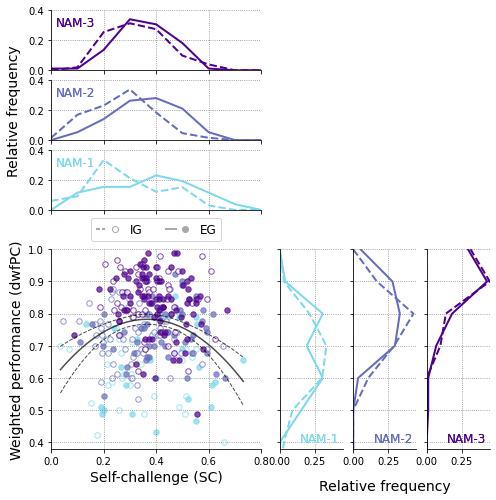

In [2]:
def make_fig(data_path, figname, save_to, save_as=''):
    xstr = 'sc_lep'
    df = lut.unpickle(data_path).sort_values(by=xstr)
    df = df.loc[df.ntm > 0, :]

    propS = np.sum(df.grp == 1) / df.shape[0]

    fig = plt.figure(figname, figsize=[7, 7])
    gs = gridspec.GridSpec(2, 2)

    # Figure (scatter plot and histograms)
    # ====================================
    ghost_top = fig.add_subplot(gs[0, 0])
    ghost_top.set_ylabel('Relative frequency', fontsize=14, labelpad=30)
    ghost_top.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
    for spine in ghost_top.spines.values(): spine.set_visible(False)

    ax_top1 = vut.pretty(inset_axes(ghost_top, width='100%', height='30%', loc=9, borderpad=0))
    ax_top2 = vut.pretty(inset_axes(ghost_top, width='100%', height='30%', loc=10, borderpad=0))
    ax_top3 = vut.pretty(inset_axes(ghost_top, width='100%', height='30%', loc=8, borderpad=0))

    ghost_right = fig.add_subplot(gs[1, 1])
    ghost_right.set_xlabel('Relative frequency', fontsize=14, labelpad=30)
    ghost_right.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
    for spine in ghost_right.spines.values(): spine.set_visible(False)
    ax_right1 = vut.pretty(inset_axes(ghost_right, width='30%', height='100%', loc=6, borderpad=0))
    ax_right2 = vut.pretty(inset_axes(ghost_right, width='30%', height='100%', loc=10, borderpad=0))
    ax_right3 = vut.pretty(inset_axes(ghost_right, width='30%', height='100%', loc=7, borderpad=0))

    ax_scat = vut.pretty(fig.add_subplot(gs[1, 0]))

    bins = np.arange(0, 1.02, .1)
    labels = {'ntm': ['NAM ' + str(i) for i in (0, 1, 2, 3)], 'grp': fullglabels}
    axes_by_ntm = {
        'top': {
            3: ax_top1,
            2: ax_top2,
            1: ax_top3},
        'right': {
            1: ax_right1,
            2: ax_right2,
            3: ax_right3}}
    for ntm in [1, 2, 3]:
        axes_by_ntm['top'][ntm].set_xlim(.0, .8)
        axes_by_ntm['top'][ntm].set_ylim(0., .4)
        axes_by_ntm['right'][ntm].set_xlim(0., .45)
        axes_by_ntm['right'][ntm].set_ylim(0.38, 1.)
        for grp in [0, 1]:
            x = df.loc[(df.ntm == ntm) & (df.grp == grp), xstr]
            y = df.loc[(df.ntm == ntm) & (df.grp == grp), 'post']
            ax_scat.scatter(x, y, s=30, alpha=.7,
                            facecolors=ncolors[ntm - 1] if grp else 'w',
                            edgecolors=ncolors[ntm - 1])

            rf, _ = np.histogram(x, bins=bins, weights=np.ones_like(x) / x.size)
            axes_by_ntm['top'][ntm].plot(bins[:-1], rf, c=ncolors[ntm - 1], lw=2,
                                         ls='-' if grp else '--',
                                         label='{} / NAM-{}'.format(glabels[grp], ntm))
            axes_by_ntm['top'][ntm].tick_params(labelbottom=False)
            axes_by_ntm['top'][ntm].text(.02, .9, 'NAM-{}'.format(ntm), ha='left', va='top', fontsize=12,
                                         color=ncolors[ntm - 1], transform=axes_by_ntm['top'][ntm].transAxes)

            rf, _ = np.histogram(y, bins=bins, weights=np.ones_like(x) / x.size)
            axes_by_ntm['right'][ntm].plot(rf, bins[1:], c=ncolors[ntm - 1], lw=2,
                                           ls='-' if grp else '--',
                                           label='{} / NAM-{}'.format(glabels[grp], ntm))
            axes_by_ntm['right'][ntm].tick_params(labelleft=False)
            axes_by_ntm['right'][ntm].text(.95, .02, 'NAM-{}'.format(ntm), ha='right', va='bottom', fontsize=12,
                                           color=ncolors[ntm - 1], transform=axes_by_ntm['right'][ntm].transAxes)

    ax_scat.set_xlim(.0, .8)
    ax_scat.set_ylim(0.38, 1.)
    ax_scat.set_xlabel('Self-challenge (SC)', fontsize=14)
    ax_scat.set_ylabel('Weighted performance (dwfPC)', fontsize=14)

    # Edit legend
    c = 'darkgray'
    mark_ig = lines.Line2D([0], [0], ls='', marker='o', label=fullglabels[0], markerfacecolor='w', markeredgecolor=c)
    line_ig = lines.Line2D([0], [0], color=c, lw=2, label=fullglabels[0], ls='--', dashes=(2, 1))

    mark_eg = lines.Line2D([0], [0], color=c, ls='', marker='o', label=fullglabels[1])
    line_eg = lines.Line2D([0], [0], color=c, lw=2, label=fullglabels[1])

    ax_scat.legend(((line_ig, mark_ig), (line_eg, mark_eg)), fullglabels.values(),
                   bbox_to_anchor=(.5, 1.1,),
                   fontsize=12, ncol=3, loc='center',
                   handler_map={tuple: legend_handler.HandlerTuple(ndivide=None)})

    # Main Model
    # ====================================
    qreg = ols('post ~ (pre + {0} + np.power({0}, 2) + grp)'.format(xstr), data=df).fit()
    x = np.linspace(df.loc[:, xstr].min(), df.loc[:, xstr].max(), 100)
    y_hat = qreg.get_prediction({xstr: x,
                                 'pre': np.full_like(x, df.pre.mean()),
                                 'grp': np.full_like(x, propS)
                                 }).summary_frame()
    display(y_hat.head())
    c, alpha = 'k', .7
    ax_scat.plot(x, y_hat['mean'], c=c, alpha=alpha)
    ax_scat.plot(x, y_hat['mean_ci_lower'], c=c, lw=1, ls='--', alpha=alpha)
    ax_scat.plot(x, y_hat['mean_ci_upper'], c=c, lw=1, ls='--', alpha=alpha)

    df.loc[:, xstr] = scs.stats.zscore(df.loc[:, xstr]) # Standardize x before fitting the quadratic model
    
    # Run quadratic regression of final performance
    qreg = ols('post ~ (pre + {0} + np.power({0}, 2) + grp)'.format(xstr), data=df).fit()
    display(qreg.summary())
    
    # Run nonquadratic regression and compare AIC
    nonqreg = ols('post ~ (pre + {0} + grp)'.format(xstr), data=df).fit()
    print('Delta AIC = {:.2f}'.format(qreg.aic - nonqreg.aic))

    # Run model of average SC as a function of Group x NAM
    lreg = ols('{} ~ C(grp) * C(ntm)'.format(xstr), data=df).fit()
    display(lreg.summary())
    
    # Show group and subgroup counts
    display(df.groupby(['grp', 'ntm'])['sid'].agg('count'))
    
    # Save figure
    fig.tight_layout()
    if save_as:
        vut.save_it(fig, save_to, figname=figname, save_as=save_as, compress=False, dpi=100)


make_fig(
    data_path='data/lpreds_data.pkl',
    figname='figure3',
    save_to='figures',
    save_as='' # File format (png, jpeg, svg, ...)
)

# Figure 4a

In [ ]:
def make_fig(data_path, figname, save_to, save_as=''):
    baseline = 693.1471805599454
    ic = 'aic'
    df = pd.read_csv(data_path)
    fdf = pd.read_csv(data_path)[['form', 'loss', ic]]
    fdf['nvars'] = 6 - df.loc[:, 'tau':'relt_coef'].isnull().sum(axis=1)
    fdf.loc[:, ic] = 2 * fdf.loss + 2 * fdf.nvars
    fdf = fdf[~fdf.form.str.contains('dLP')]
    fdf = fdf[~fdf.form.str.contains('mLP')]
    fdf = fdf[~fdf.form.str.contains('RELT')]
    fdf.replace(['rLP', 'PC + rLP'], ['LP', 'PC + LP'], inplace=True)
    byform = fdf.set_index('form')

    fdf = fdf.loc[:, ('form', 'aic')].groupby(['form']).agg(['mean', 'std'])
    fdf = fdf.sort_values(by=(ic, 'mean'), ascending=True)
    display(fdf)

    fig = plt.figure(figname, figsize=(5, 3.5))
    ax = vut.pretty(fig.add_subplot(111), 'x')

    fdf = fdf.sort_values(by=(ic, 'mean'), ascending=False)
    sns.violinplot(x=ic, y='form', data=byform.reset_index(), ax=ax,
                   color='lightgray', linewidth=1.5, order=fdf.index)
    for v in ax.collections: v.set_edgecolor('w')

    ax.axvline(baseline, ls='--', zorder=3, color='red',
               label='Random model')
    ax.set_ylabel('Model', fontsize=14)
    ax.set_xlabel('AIC', fontsize=14)
    ax.set_xlim([200, 800])
    ax.legend()

    print('Baseline AIC = {}'.format(baseline))
    fig.tight_layout()
    if save_as:
        vut.save_it(fig, save_to, figname=figname, save_as=save_as, compress=False, dpi=100)


make_fig(
    data_path='data/choiceModelComparison_PC_dLP_rLP_mLP_RELT_300seeds.csv',
    figname='figure4a',
    save_to='figures',
    save_as='' # File format (png, jpeg, svg, ...)
)

# Figure 4b

Figure 4b was prepared in R. The figure can be reproduced by running an R script stored in *R_scripts/figure4b.R*